We will use three packages from Julia.

In [20]:
using Symbolics, LinearAlgebra, Catalyst, Plots

We use catalyst package to formally define a chemical reaction using "@reaction_network"

3.6.1 Simple Reversible Reaction Network

In [23]:
crn1 = @reaction_network begin
    k, A --> B
    1.0, B --> A
end

Model ##ReactionSystem#273
States (2):
  A(t)
  B(t)
Parameters (1):
  k

We create the transition matrix for this example:

In [24]:
@variables k
#we use only one variable k as defining two separate variables kf (forward rate) and kb (backward rate) will create excess storage
#as in the end, we are only interested in the ratio of kf and kb which is our k
N=3 #total number of molecules in the system
states = N + 1
P = Matrix{Num}(undef, states, states)
for i in 1:states, j in 1:states
    P[i, j] = 0
end
for i in 0:N
    if i < N
        P[i+1, i+2] = k * (N - i)  # Pi,i+1
    end
    if i > 0
        P[i+1, i] = k * i         # Pi,i-1
    end
    P[i+1, i+1] = -(k * (N - i) + k * i)  # Pi,i
end
P #transition matrix (laplacian as well in the continuous time)

4×4 Matrix{Num}:
 -3k   3k    0    0
   k  -3k   2k    0
   0   2k  -3k    k
   0    0   3k  -3k

We now use MCTT to compute the stationary distribution:

In [25]:
function mctt_for_crn1(k::Float64, N::Int64)
    states = N + 1
    P = Matrix{Float64}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = 0.0
    end
    for i in 0:N
        if i < N
            P[i+1, i+2] = 1*(N-i)  # Pi,i+1
        end
        if i > 0
            P[i+1, i] = k* (i)         # Pi,i-1
        end
        P[i+1, i+1] = -(k * (i) + 1 *(N-i))  # Pi,i
    end
    n=N+1
    A= P
    z=Float64[]
    for i in 1:n
        minor = A[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z,pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    return values
end

mctt_for_crn1 (generic function with 1 method)

Generating Distributions by CRN for various values of parameter (rate constant)

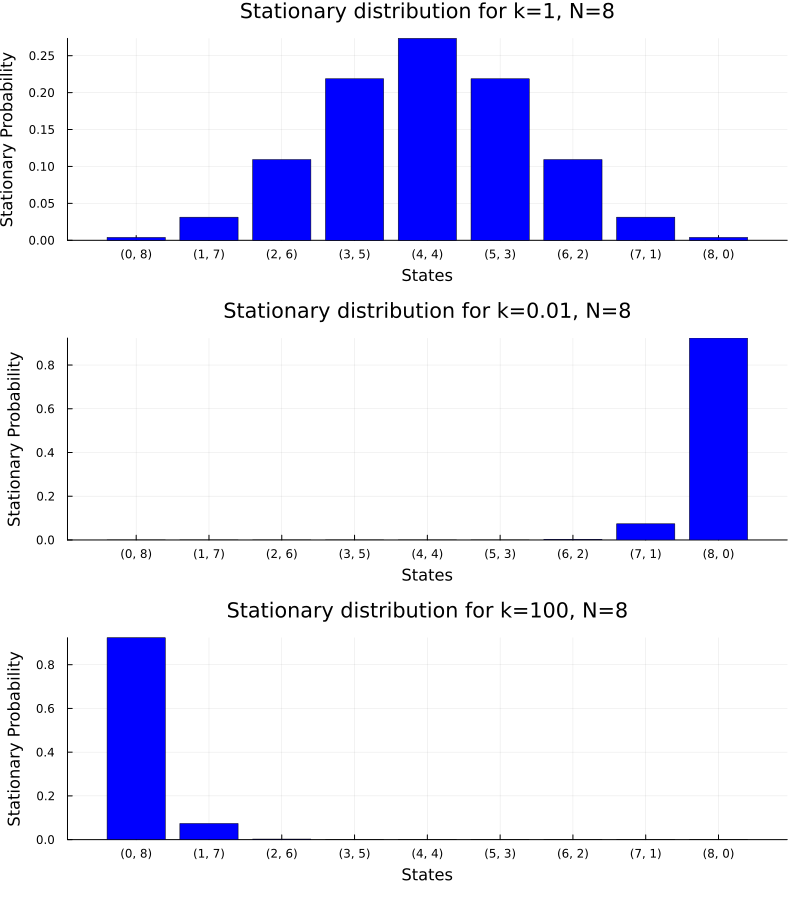

In [26]:
values1 = mctt_for_crn1(1.0,8) #when kf = kb and total molecules in the system be 8
values2 = mctt_for_crn1(0.01,8) #when kf << kb say kf = 0.01*kb 
values3 = mctt_for_crn1(100.0,8) #when kf >> kb say kf = 100*kb
x_labels = ["($i, $(8-i))" for i in 0:8]
# Create a combined plot with 3 vertical subplots
combined_plot = plot(layout=(3, 1), size=(800, 900))
# Plot each subgraph
bar!(combined_plot[1], values1,
    title="Stationary distribution for k=1, N=8",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:9, x_labels),
    color=:blue,
    width=0.5,
    legend=false)

bar!(combined_plot[2], values2,
    title="Stationary distribution for k=0.01, N=8",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:9, x_labels),
    color=:blue,
    width=0.5,
    legend=false)

bar!(combined_plot[3], values3,
    title="Stationary distribution for k=100, N=8",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:9, x_labels),
    color=:blue,
    width=0.5,
    legend=false)

# Adjust layout spacing
plot!(combined_plot)
display(combined_plot)

3.6.2 Simple Reversibile Reaction with Three Species

In [27]:
crn2 = @reaction_network begin
    k, A + B --> 2*C
    1.0, 2*C --> A + B
end

Model ##ReactionSystem#282
States (3):
  A(t)
  B(t)
  C(t)
Parameters (1):
  k

In [30]:
function mctt_for_crn2(k::Float64, N::Int64, M::Int64) #defining function to compute stationary distribution for crn2
    Z = (N-M)/2
    Z= Int64(Z)
    states = Z + 1
    P = Matrix{Float64}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = 0.0
    end
    for i in 0:Z
        if i < Z
            P[i+1, i+2] = (N-M-2*i)*(N-M-2*i-1)/2
        end
        if i > 0
            P[i+1, i] = k*i*(i+M) # Pi,i-1
        end
        P[i+1, i+1] = -(N-M-2*i)*(N-M-2*i-1)/2-k*i*(i+M)
    end
    A= P
    n=Z+1
    z=Float64[]
    for i in 1:n
        minor = A[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z,pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    return values
end

mctt_for_crn2 (generic function with 1 method)

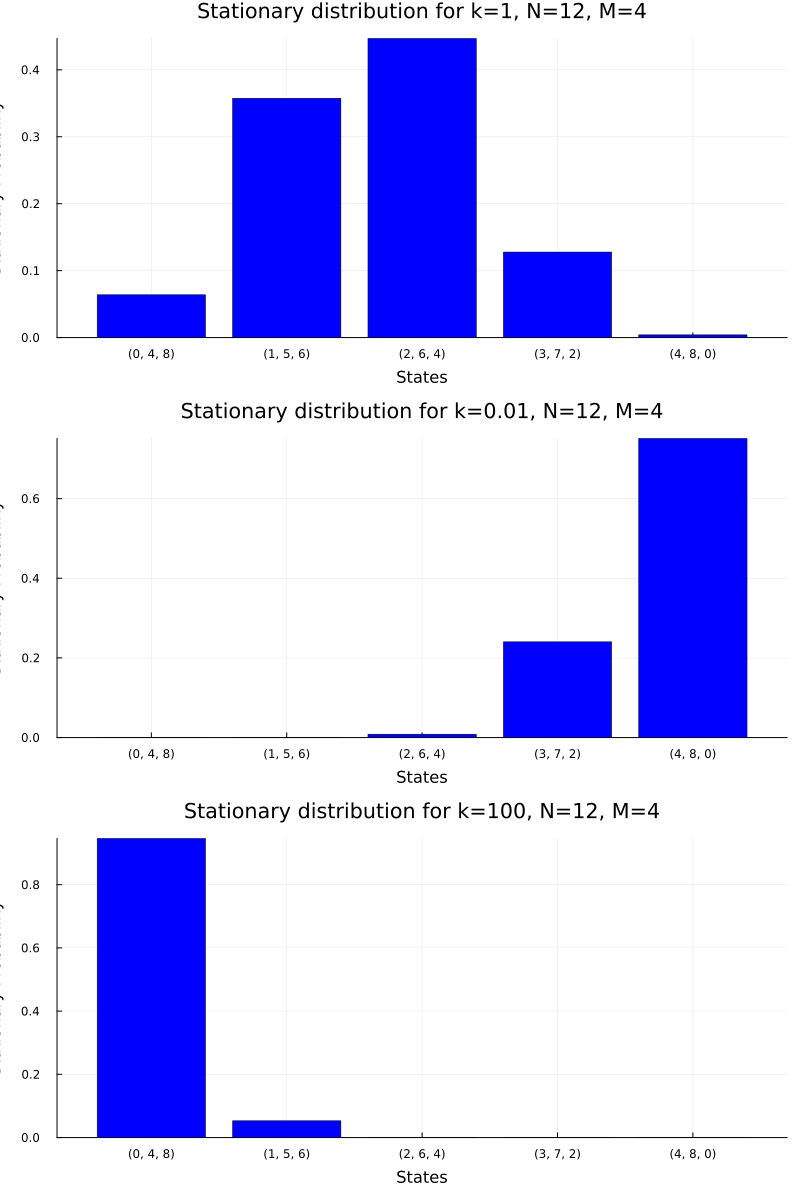

In [34]:
values1 = mctt_for_crn2(1.0,12,4) #when kf = kb and total molecules in the system be 8
values2 = mctt_for_crn2(0.01,12,4) #when kf << kb say kf = 0.01*kb 
values3 = mctt_for_crn2(100.0,12,4) #when kf >> kb say kf = 100*kb
N=12
M=4
Z=4
x_labels = ["($i, $(i+4), $(N-M-2*i))" for i in 0:Z]
# Create a combined plot with 3 vertical subplots
combined_plot = plot(layout=(3, 1), size=(800, 1200))
# Plot each subgraph
bar!(combined_plot[1], values1,
    title="Stationary distribution for k=1, N=12, M=4",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:5, x_labels),
    color=:blue,
    width=0.5,
    legend=false)

bar!(combined_plot[2], values2,
    title="Stationary distribution for k=0.01, N=12, M=4",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:5, x_labels),
    color=:blue,
    width=0.5,
    legend=false)

bar!(combined_plot[3], values3,
    title="Stationary distribution for k=100, N=12, M=4",
    xlabel="States", 
    ylabel="Stationary Probability",
    xticks=(1:5, x_labels),
    color=:blue,
    width=0.5,
    legend=false)
# Adjust layout spacing
plot!(combined_plot)
display(combined_plot)

Converged after 6623 iterations
Optimal k found: 0.29261416817692243


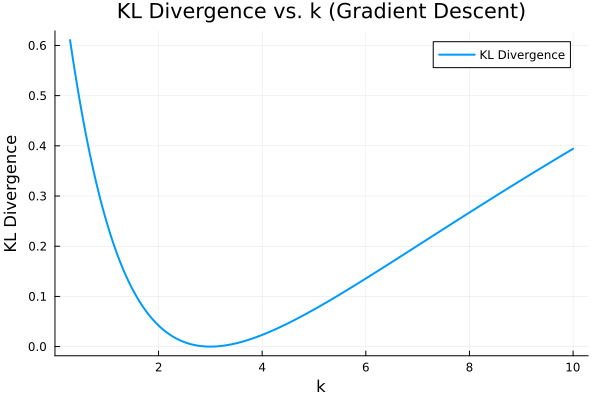

In [19]:
using LinearAlgebra
using ForwardDiff
using Plots
# Modify the function to accept any Real type
function model_for_crn1(k::T, N::Int64) where T<:Real
    states = N + 1
    P = Matrix{T}(undef, states, states)
    for i in 1:states, j in 1:states
        P[i, j] = zero(T)
    end
    for i in 0:N
        if i < N
            P[i+1, i+2] = one(T) * (N - i)  # Pi,i+1
        end
        if i > 0
            P[i+1, i] = k * i     # Pi,i-1
        end
        P[i+1, i+1] = -(one(T) * (N - i) + k * i)  # Pi,i
    end
    n = N + 1
    IN = Matrix{T}(I, n, n)
    A = P - IN
    z = T[]
    for i in 1:n
        minor = A[[1:i-1; i+1:n], [1:i-1; i+1:n]]
        pi = det(minor)
        push!(z, pi)
    end
    s = sum(z)
    values = [zi / s for zi in z]
    
    return values
end

# True data for k=34.0 and N=16
true_data = model_for_crn1(3.0, 8)

function kl_divergence(true_data, model_data)
    # Normalize both distributions
    true_data = true_data / sum(true_data)
    model_data = model_data / sum(model_data)
    
    # Calculate KL divergence
    divergence = sum(true_data .* log.(true_data ./ model_data))
    return divergence
end

function objective_function(k::T) where T<:Real
    model_data = model_for_crn1(k, 8)
    return kl_divergence(true_data, model_data)
end

gradient_objective = k -> ForwardDiff.derivative(objective_function, k)

k=10.0
learning_rate=0.01
tolerance = 1e-6
max_iters=10000

k_values = Float64[]  # To store k values
divergences = Float64[]  # To store corresponding divergences

for iter in 1:max_iters
    grad = gradient_objective(k)[1]  # Compute the gradient at the current k
    k_new = k - learning_rate * grad  # Update k using gradient descent
    # Store the k value and corresponding divergence
    push!(k_values, k)
    push!(divergences, objective_function(k))
    # Check for convergence
    if abs(k_new - k) < tolerance
        println("Converged after $iter iterations")
        break
    end

    k = k_new
end

# Initial guess for parameters
initial_params = [1.0, 1.5, 2.0, 7.5]

println("Optimal k found: ", k)
plot(k_values, divergences, xlabel="k", ylabel="KL Divergence", title="KL Divergence vs. k (Gradient Descent)", label="KL Divergence", lw=2)
